In [10]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import torch
from sklearn.decomposition import PCA
from agents.networks.gru_rnn import GRU_RNN

AVERAGING_SIZE = 20

color_set_1 = [
    '#E4F1F7',
    '#C5E1EF',
    '#9EC9E2',
    '#6CB0D6',
    '#3C93C2',
    '#226E9C',
    '#0D4A70',
    '#054166',
]

color_set_2 = [
    '#F9D8E6',
    '#F2ACCA',
    '#ED85B0',
    '#E95694',
    '#E32977',
    '#C40F5B',
    '#8F003B',
    '#69022c',
]

HIDDEN_SIZE = 32
INPUT_SIZE = 1

In [11]:
hypo_data = [
    'line_attr_init_test_0_act_reg_2024-12-18_13_03_47_846851_var_noise_5e-05_activity_weight_1e-07',
]

ctrl_data = [
]

In [12]:
def load_numpy(data_path, averaging_size=1, concat_ax=0):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=concat_ax)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

In [13]:
hidden_state_data = None
for i_d, d in enumerate(hypo_data):
    hs_path = f'../../results/line_attr_supervised/{d}/hidden_states/*.npy'
    o_path = f'../../results/line_attr_supervised/{d}/outputs/*.npy'
    hidden_state_data = load_numpy(hs_path)
    output_data = load_numpy(o_path, concat_ax=1)

print(hidden_state_data.shape)

(2000, 32, 500)


(2, 2000)


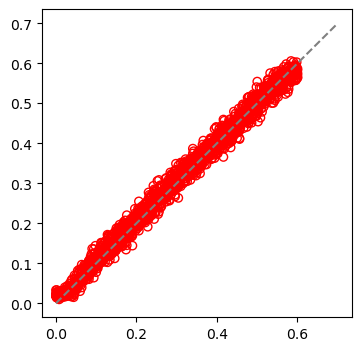

In [15]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

# output_data = output_data.reshape((2, 2000), order='F')
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], output_data[0, :], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')

[0.00971907 0.01229048 0.01399213 ... 0.6028151  0.6033016  0.60575956]
0
200
400
600
800
1000
1200
1400
1600
1800


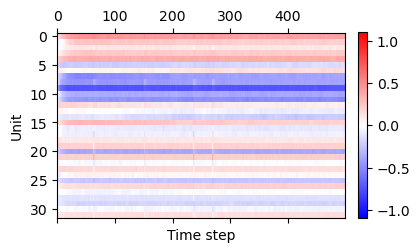

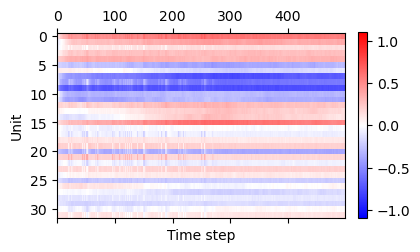

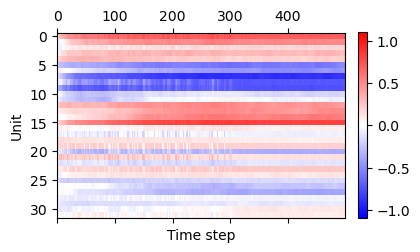

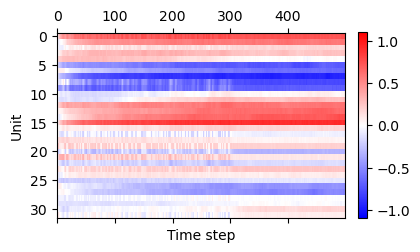

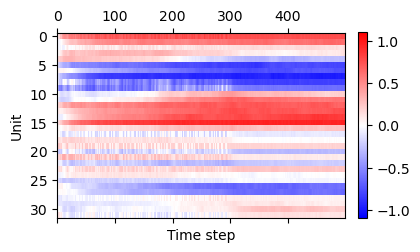

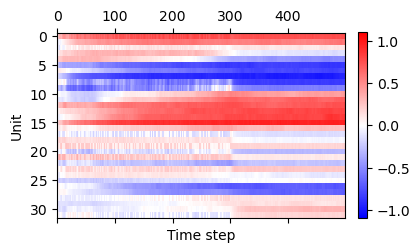

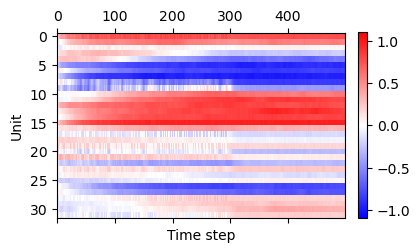

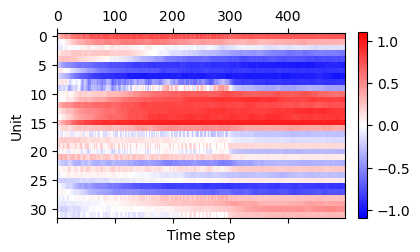

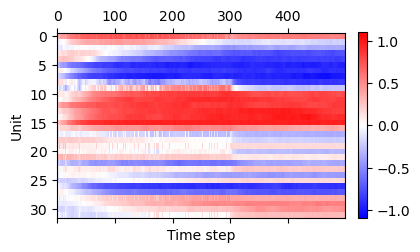

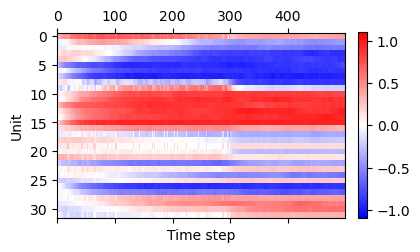

In [16]:
m = np.abs(hidden_state_data).max()

sorted_hidden_activity = hidden_state_data[output_data[0, :].argsort(), ...]

print(output_data[0, :][output_data[0, :].argsort()])

for k in range(0, 2000, 200):
    print(k)
    hidden_activity = sorted_hidden_activity[k, ...]
    
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    axs.set_ylabel('Unit')
    axs.set_xlabel('Time step')

    cbar = axs.matshow(hidden_activity, vmin=-m, vmax=m, cmap='bwr', aspect=10)
    plt.colorbar(cbar, fraction=0.03, pad=0.04)

# PC space representation

(32, 2000, 500)
(32, 1000000)
[[-6.38092635e-03 -1.30855173e-01 -1.42087206e-01 -2.68452317e-01
  -3.42592716e-01 -1.67918459e-01 -2.35379592e-01 -1.06209658e-01
  -4.34416197e-02  2.34529957e-01  3.24038774e-01  3.55828226e-01
   1.72010332e-01  2.15113759e-01  2.29974225e-01  1.37536421e-01
   1.29753202e-01 -6.43456206e-02 -6.69956580e-02 -2.45332662e-02
   4.68104780e-02 -1.41024012e-02 -1.16175644e-01 -4.74139088e-04
  -1.41599879e-01  1.11629575e-01 -2.68761963e-01 -1.63330227e-01
   1.37324095e-01  1.88059762e-01  1.17621705e-01  2.69037988e-02]
 [ 2.58472145e-01  4.90829229e-01  2.63079196e-01  2.54804343e-01
   4.67827916e-02 -1.26988888e-01 -2.05709681e-01 -2.07354307e-01
  -3.00588667e-01 -3.14699322e-01 -5.95975332e-02  1.10743031e-01
   8.40694159e-02  1.57754198e-01  2.44290337e-01  2.14502037e-01
   1.42094614e-02  6.33595511e-02  9.96311568e-03  3.41665633e-02
  -8.63949209e-02 -6.22585751e-02  5.08741513e-02  6.82085082e-02
   1.56885952e-01 -3.45962159e-02 -1.20279118

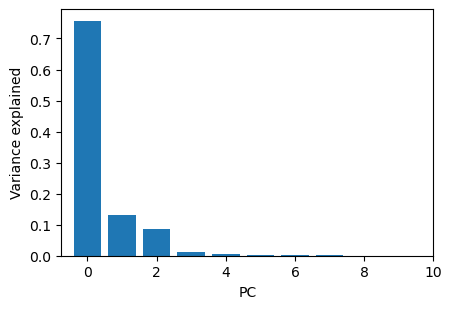

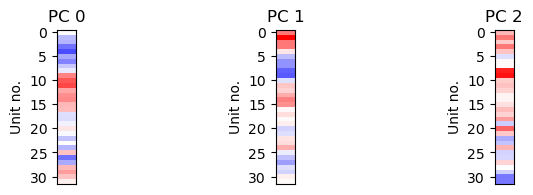

In [33]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 2

print(pca.components_[:3, :])
fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
m = np.abs(pca.components_[:3, :]).max()
for i in range(3):
    axs[i].matshow(pca.components_[i, :].reshape(HIDDEN_SIZE, 1), vmin=-m, vmax=m, cmap='bwr', aspect=0.25)
    axs[i].set_xticks([])
    axs[i].set_ylabel('Unit no.')
    axs[i].set_title(f'PC {i}')

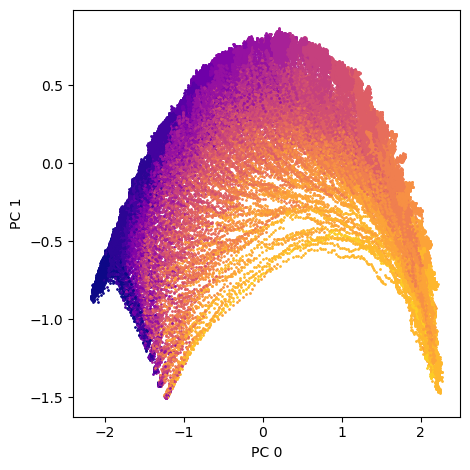

In [34]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))

for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k],
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

(32, 2000, 500)
(32, 1000000)


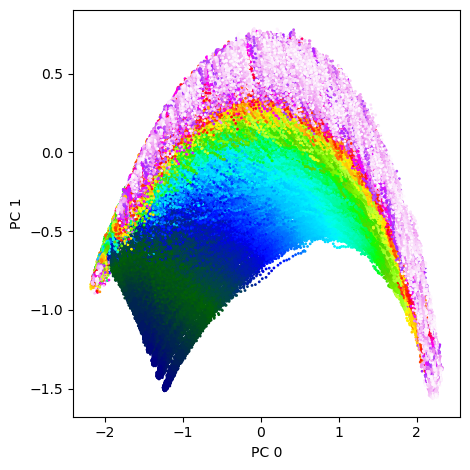

In [61]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['gist_ncar']
colors = cmap(np.linspace(0, 1, 300))

sorted_hidden_activity = hidden_state_data[output_data[0, :].argsort(), ...]
data_ = np.transpose(sorted_hidden_activity, [1, 0, 2])
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)

for run_idx in reversed(range(0, 2000, 1)):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1) - 200, k],
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1) - 200, k + 1],
            s=1,
            color=colors[np.arange(300)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

(20, 2000, 500)
(20, 1000000)
[[-0.00675338 -0.14691314 -0.1601701  -0.30130258 -0.38568363 -0.18995203
  -0.2652206  -0.11933111 -0.04503497  0.26881093  0.36673468  0.4025607
   0.19485056  0.24281974  0.25951084  0.155462    0.1475062  -0.07195974
  -0.07412765 -0.02840965]
 [ 0.28036636  0.5297597   0.28083044  0.27894837  0.05261487 -0.1382422
  -0.21781635 -0.21950951 -0.29650894 -0.3079705  -0.05628758  0.12415515
   0.09436344  0.16902003  0.26055995  0.23075986  0.02231428  0.06931385
   0.01952209  0.03033764]
 [ 0.14815165  0.29219952  0.11817627  0.30684897  0.14900678 -0.04905231
   0.05221229  0.04923792  0.5499698   0.5652795   0.10340716  0.10864591
   0.0795155  -0.00689713 -0.01699215  0.03457141  0.14727691  0.10971142
   0.23613329 -0.11377229]]


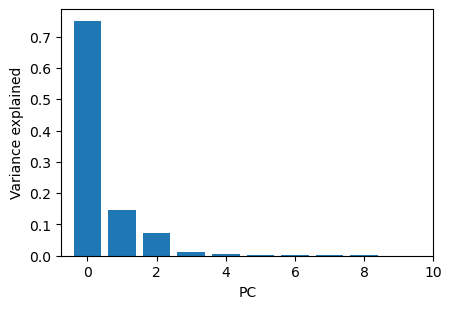

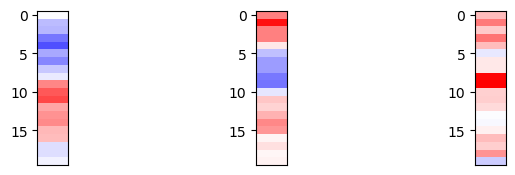

In [21]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
data_ = data_[:20, ...]
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 2

print(pca.components_[:3, :])
fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
m = np.abs(pca.components_[:3, :]).max()
for i in range(3):
    axs[i].matshow(pca.components_[i, :].reshape(20, 1), vmin=-m, vmax=m, cmap='bwr', aspect=0.25)
    axs[i].set_xticks([])

C:\Users\david.bell\AppData\Local\Temp\ipykernel_21292\621727634.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs.scatter(


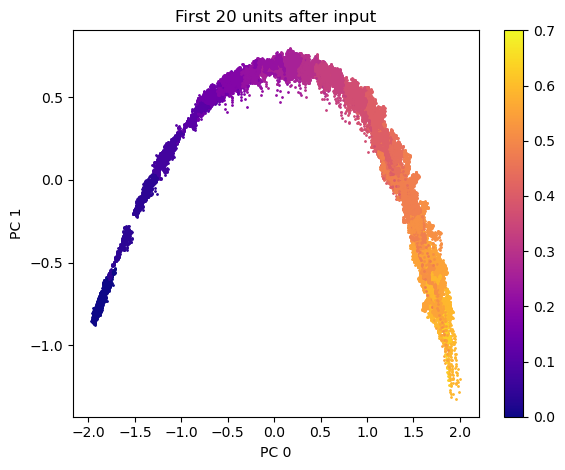

In [22]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(5 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        axs.scatter(
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            c=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
plt.colorbar(sm, ax=axs)
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
axs.set_title('First 20 units after input')
    # fig.colorbar(cbar)
fig.tight_layout()

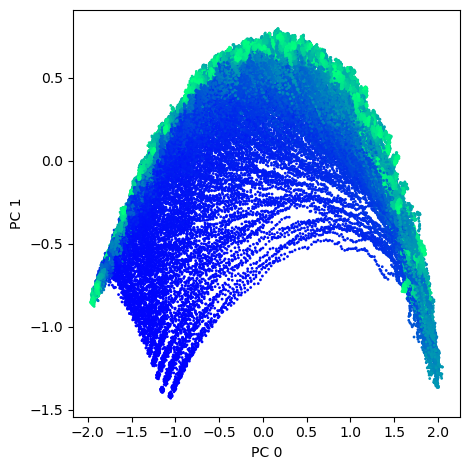

In [24]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

(12, 2000, 500)
(12, 1000000)


Text(0.5, 0, 'PC')

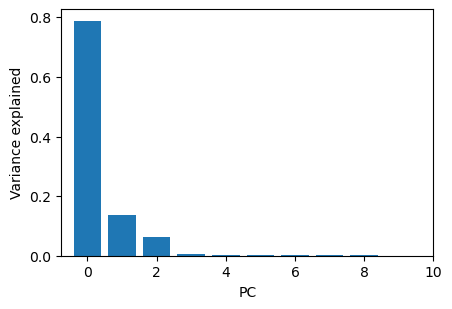

In [25]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
data_ = data_[20:, ...]
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

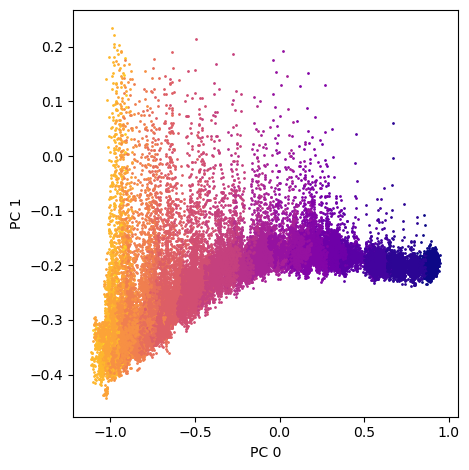

In [26]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

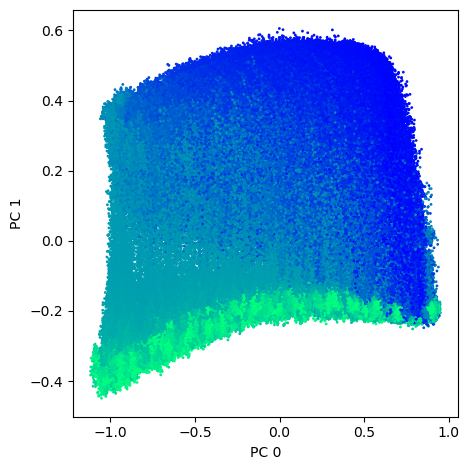

In [27]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))


for run_idx in range(0, 1000, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

In [29]:
all_w_hh_trained = []
all_w_out = []
all_b_out = []

for i_d, d in enumerate(hypo_data):

    network_trained = GRU_RNN(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=1e-7,
    )
    
    load_path = f'../../results/line_attr_supervised/{d}/rnn_weights/weights.h5'
    network_trained.load_state_dict(torch.load(load_path, weights_only=True))
    
    w_hh_trained = network_trained.rnn.weight_hh.detach().numpy()
    all_w_hh_trained.append(w_hh_trained)

    all_w_out.append(network_trained.output_arm.weight.detach().numpy())
    all_b_out.append(network_trained.output_arm.bias.detach().numpy())

(2000, 32, 500)
(2, 2000)


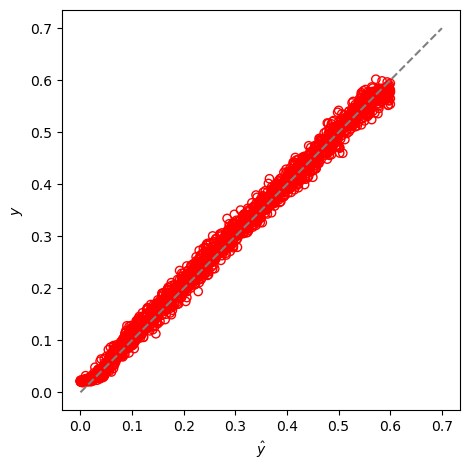

In [30]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten(), (hidden_state_data[..., 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'$y$')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()

(2000, 32, 500)
(2, 2000)


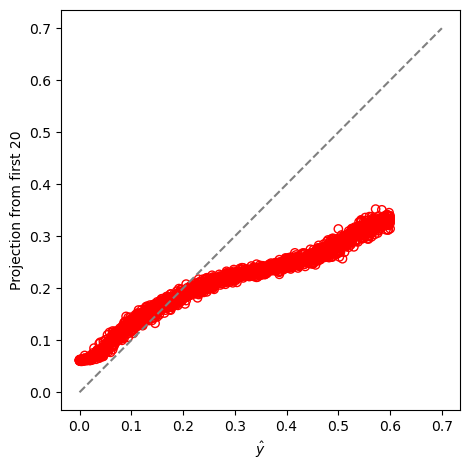

In [31]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten()[:20], (hidden_state_data[:, :20, 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'Projection from first 20')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()

(2000, 32, 500)
(2, 2000)


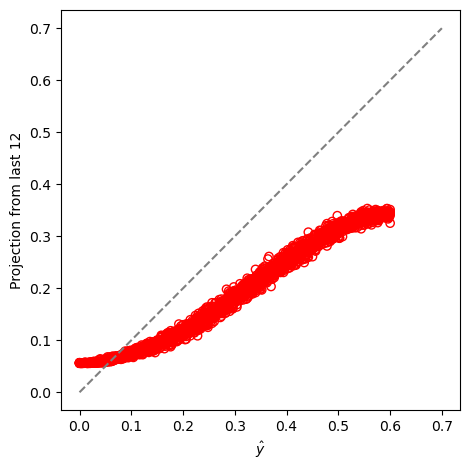

In [32]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten()[20:], (hidden_state_data[:, 20:, 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'Projection from last 12')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()